<a href="https://colab.research.google.com/github/guriosam/INF2922_Raio_X/blob/main/Engenharia_de_Software_para_Ci%C3%AAncia_de_Dados_Caio_Barbosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avaliação de Resultados de Raios-X de Pulmão para Diferenciar Pulmões com Pneunomia Bacteriana e Pneunomia Viral.**

Dataset e problema: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia



# **Histórias de Usuário**

## US01 - **Como um** médico pneumologista **Eu quero** ser capaz de distinguir pulmões com pneumonia viral de bacteriana **De forma que** os diagnósticos sejam feitos de forma mais rápida.

### ML Problem and Context: 

Problema de classificação. Classificar raios-x de pulmões entre pneunomia viral ou bacteriana.


### Organizational Goals: 

Diminuir o tempo das consultas.

### User Goals: 

Diminuir o tempo entre diagnósticos.

### Model Goals: 

Precisão > 80%, Recall > 70%

### ML Functionality: 

Classificar os raios-x em 2 grupos diferentes:
1. Pneumonia Viral
2. Pneumonia Bacteriana

### Customer Expectations: 

Em menos de um minuto.



# 1. Definição do Problema



A implementação de algoritmos de suporte à decisão clínica para imagens médicas enfrenta desafios com confiabilidade e interpretabilidade. 

De forma a agilizar os diagnósticos, é necessário criar uma ferramenta capaz de decidir se uma pneumonia é bacteriana ou viral apenas com a imagem de um raio-x do pulmão.

Informações sobre o dataset:

O dataset está organizado em 3 pastas (train, test, e val), contendo subpastas pra cada categoria de imagem (Pneumonia/Normal). Existem 5.863 imagens de raios-x no formato JPEG, e duas categorias (Pneumonia e Normal).

As imagens de raio-x foram selecionadas cortes retrospectivos de pacientes pediátricos de 1 a 5 anos do hopistal Guangzhou Women and Children’s Medical Center, localizado em Guangzhou. Todos os raios-x foram tirados durante os cuidados de dia-a-dia dos pacientes.

Para serem usadas, as imagens de raio-x foram escrutinizadas para garantir a qualidade das imagens, removendo as que possuiam baixa qualidade ou ilegiveis. Os diagnósticos (etiquetas) foram dados por dois médicos especialistas, e no caso não concordância, as imagens foram vistas por mais um especialista.

In [ ]:
# Instalando libs que estão não nativamente no colab

!pip install captum
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports

import os
import random
import numpy as np
import pandas as pd

import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Subset

from google.colab import files, drive

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, precision_recall_curve,
roc_curve, roc_auc_score, classification_report)
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import Image, display
import matplotlib.cm as cm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 2. Carga de Dados

In [ ]:
# Reproducibilidade:
# Caso dê erro nessa célula, é necessário baixar o arquivo kaggle.json com uma chave de API pro uso no colab

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Movendo o arquivo .kaggle para a pasta onde a API espera encontrá-lo.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip /content/chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Montando o drive para salvar informações
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Para reprodutibilidade
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)


In [ ]:
data_dir = '/content/chest_xray/chest_xray/'

In [ ]:
# Pra melhorar a qualidade dos plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [ ]:
def image_shape(filepath):
    "Retorna altura e largura da imagem"
    return np.array(Image.open(filepath)).shape

In [ ]:
fileslist = []
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if not filename.startswith('.'):
            fileslist += [os.path.join(dirname, filename)]


In [ ]:
s1 = pd.Series(fileslist)
size = s1.str.lower().str.split("/", expand=True).shape[1]

s2 = s1.str.lower().str.split("/", expand=True)[size - 3]
s3 = s1.str.lower().str.split("/", expand=True)[size - 2]
df = pd.concat([s1, s2, s3],axis=1)
df.columns = ['filepath', 'phase','type']

# 3. Exploração dos Dados

## 3.1 Estatísticas Descritivas e Visualizações

(127.0, 2713.0)

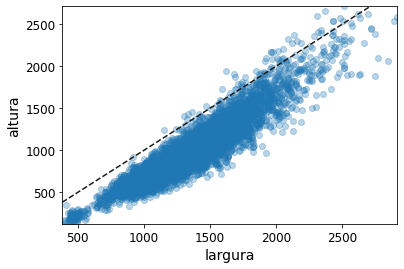

In [ ]:
# Observando altura e largura das imagens do dataset

df['h'], df['w'] = zip(*s1.apply(image_shape)) # altura e largura das imagens

plt.scatter(df.w, df.h,  alpha=0.3)
x = np.arange(0,3000)
y = np.arange(0,3000)
plt.plot(x,y, 'k--')
plt.xlim([df.h.min(),df.h.max()])
plt.ylabel('altura')
plt.xlabel('largura')
plt.xlim([df.w.min(),df.w.max()])
plt.ylim([df.h.min(),df.h.max()])


In [ ]:
df.head()

,filepath,phase,type,h,w
0,/content/chest_xray/chest_xray/val/PNEUMONIA/p...,val,pneumonia,952,1192
1,/content/chest_xray/chest_xray/val/PNEUMONIA/p...,val,pneumonia,944,1416
2,/content/chest_xray/chest_xray/val/PNEUMONIA/p...,val,pneumonia,664,1152
3,/content/chest_xray/chest_xray/val/PNEUMONIA/p...,val,pneumonia,656,1016
4,/content/chest_xray/chest_xray/val/PNEUMONIA/p...,val,pneumonia,592,968


In [ ]:
# Observando a divisão de treino/validaçã/teste do dataset
df_2 = pd.crosstab(df["phase"],df["type"]).reset_index().rename_axis(None,axis=1)
df_2 = df_2.set_index('phase').T
df_2 = df_2[['train','val','test']]
df_2

phase,train,val,test
normal,1341,8,234
pneumonia,3875,8,390


[Text(0.5, 1.0, 'train'), Text(0.5, 1.0, 'validation'), Text(0.5, 1.0, 'test')]

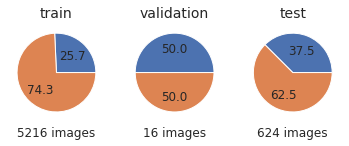

In [ ]:
sns.set_theme(style="whitegrid")
title = ['train','validation','test']
samples = [str(5216), str(16), str(624)]
axis = df_2.plot.pie(subplots=True, autopct='%.1f', labels=None)

[ax.get_legend().remove() for ax in axis]
[ax.set_ylabel('') for ax in axis]
[ax.set_xlabel(samples[idx] + ' images') for idx,ax in enumerate(axis)]
[ax.set_title(title[idx], fontsize=14) for idx,ax in enumerate(axis)]

[None, None, None]

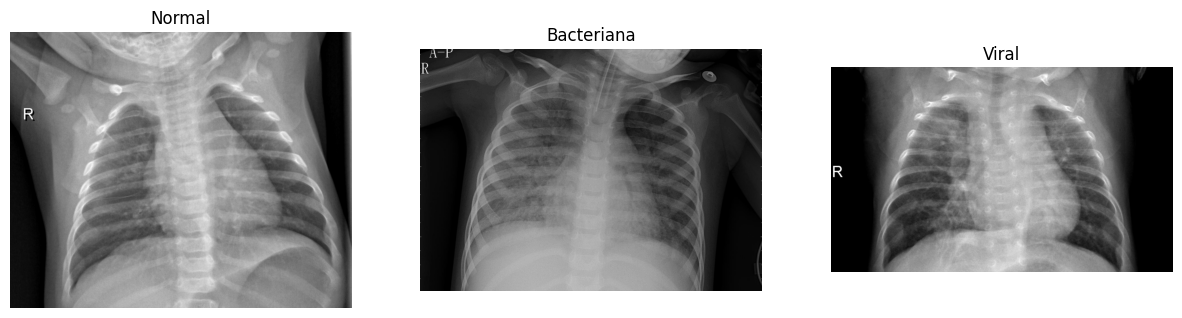

In [ ]:
# Observando as imagens do dataset

sns.reset_defaults()
img_normal = Image.open(os.path.join(data_dir, 
                            "train/NORMAL/IM-0355-0001.jpeg"))
img_bacteriana = Image.open(os.path.join(data_dir, 
                            "train/PNEUMONIA/person1576_bacteria_4124.jpeg"))
img_viral = Image.open(os.path.join(data_dir, 
                            "train/PNEUMONIA/person438_virus_889.jpeg"))

fig, axs = plt.subplots(1,3,figsize=(15,6))
axs[0].imshow(img_normal, cmap='gray',vmin=0, vmax=255)
axs[0].set_title("Normal")
axs[1].imshow(img_bacteriana, cmap='gray',vmin=0, vmax=255)
axs[1].set_title("Bacteriana")
axs[2].imshow(img_viral, cmap='gray',vmin=0, vmax=255)
axs[2].set_title("Viral");
[ax.axis('off') for ax in axs]
[ax.grid('off') for ax in axs]

# 4. Pré-processamento dos dados

In [ ]:
# Transformando imagens do dataset

transform_image = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=256),
    transforms.ToTensor()
    ])

Text(0.5, 1.0, 'Cortada')

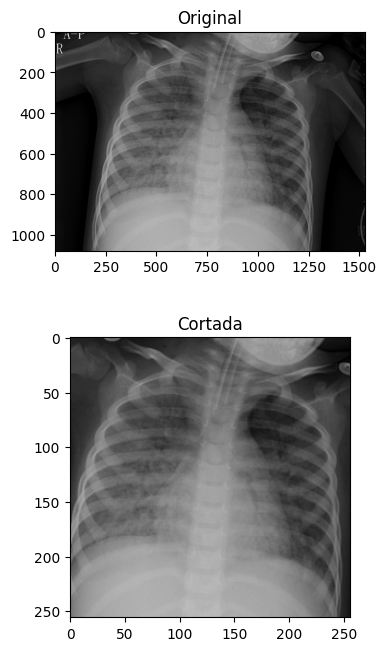

In [ ]:
shape = (256,256)
fig, axs = plt.subplots(2,1,figsize=(4,8))
img = img_bacteriana
img_t = transform_image(img).numpy().reshape(shape)
axs[0].imshow(img, cmap='gray',vmin=0, vmax=255)
axs[0].set_title("Original")
axs[1].imshow(img_t*255, cmap='gray',vmin=0, vmax=255)
axs[1].set_title("Cortada")

In [ ]:
# Observando transformações

size = 256
extra = 10

transform_1 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size+extra),
    transforms.CenterCrop(size),
    transforms.ToTensor()
    ])
transform_2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(size+extra, scale=(0.8, 1.0)),
    transforms.CenterCrop(size), 
    transforms.ToTensor(),
    ])
transform_3 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size+extra),
    transforms.RandomRotation(degrees=10),
    transforms.CenterCrop(size), 
    transforms.ToTensor(),
    ])
transform_4 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size+extra),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size), 
    transforms.ToTensor(),
    ])

transform_all = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(size+extra, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size), 
    transforms.ToTensor(),
    ])

In [ ]:
transform_dict = {'Resize':transform_1, 'RandomResizedCrop': transform_2, 
                  'RandomRotation': transform_3, 'RandomHorizontalFlip':transform_4}

In [ ]:
def plot_augment(img, shape=(256,256), random_seed=4):
    fig, axis = plt.subplots(2,2,figsize=(15,6),sharex=True, sharey=True)
    for idx,key in enumerate(transform_dict.keys()):
        torch.manual_seed(random_seed)
        random.seed(random_seed)
        i = idx%2
        j = idx//2
        img_t = transform_dict[key](img).numpy().reshape(shape)*255
        axis[i,j].imshow(img_t, cmap='gray',vmin=0, vmax=255)
        axis[i,j].set_title(key)
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        plt.tight_layout()
[ax.axis('off') for ax in axis]

[(-1.25, 1.25, -1.25, 1.25),
 (-1.25, 1.25, -1.25, 1.25),
 (-1.25, 1.25, -1.25, 1.25)]

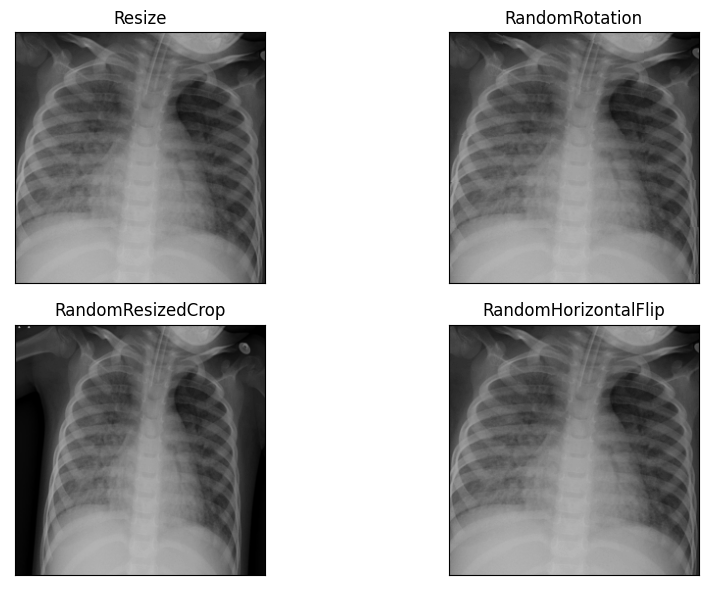

In [ ]:
plot_augment(img_bacteriana)


In [ ]:
# Dataset já está separado em treino, teste e validação.

# 5. Modelagem e Inferência

In [ ]:
IMAGES_PATH = '/content/gdrive/MyDrive/models_colab/'
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')



In [ ]:
## Para plot de métricas

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=14) 
    plt.xlabel("Threshold", fontsize=14)        
    plt.grid(True)   
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate', fontsize=14) 
    plt.ylabel('True Positive Rate', fontsize=14)    
    plt.grid(True)  

def plot_confusion_matrix(matrix):
    labels = ['Normal', 'Pneumonia']
    cmap = sns.light_palette("Navy", as_cmap=True)
    g = sns.heatmap(matrix, annot=True, cmap=cmap,
                fmt='g', square=True, xticklabels=labels, yticklabels=labels, cbar_kws={"shrink": .68,"orientation": "horizontal"})
    return g

In [ ]:
def info4metrics(model, test_dir = '/content/chest_xray/test', size = 224, batch_size = 64, grayscale=False):
    
    transform = transforms.Compose([
        transforms.Resize(size + 16),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    if grayscale == True:
      transform = transforms.Compose([
          transforms.Grayscale(),
          transforms.Resize(128 + 12),
          transforms.CenterCrop(128),
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))])
    
    dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    model = model.eval()
    y_list, y_pred_list, y_score_list = test(model, device, test_loader, criterion)
    
    y_test = np.array(y_list).reshape(-1,1)
    y_pred = np.array(y_pred_list)
    y_scores = np.array(y_score_list)
    
    return y_test, y_pred, y_scores

def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    pred_list = []
    score_list = []
    target_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item() * data.size(0) # sum up batch loss
            #p = torch.nn.functional.softmax(output, dim=1)
            score = torch.nn.functional.softmax(output, dim=1).max(dim=1, keepdim=True).values
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            score_list += score.tolist()
            pred_list += pred.tolist()
            target_list += target.tolist()
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return target_list, pred_list, score_list


In [ ]:
def get_numpy(datadir):
    '''get numpy arrays from images'''
    transform_all = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(size=35),
        transforms.CenterCrop(size=32),
        transforms.ToTensor()
        ])

    dataset = datasets.ImageFolder(datadir, transform=transform_all)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle = True)
    images, labels = next(iter(dataloader))

    X = images.view(len(dataset),-1).numpy()
    y = labels.view(len(dataset)).numpy()
    
    return X, y

## CNN

In [ ]:
class CNNEval:

  def __init__(self):
    self.training_set = None
    self.train_datagen = None
    self.test_set = None
    self.test_datagen = None
    self.cnn = None

  def generate_train_data(self):
    self.train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
    
  def generate_training_set(self):
    self.training_set = self.train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
    
  def generate_test_data(self):
    self.test_datagen = ImageDataGenerator(rescale = 1./255)
    
  def generate_test_set(self):
    self.training_set = self.test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

  def start_cnn(self):
    # Iniciando CNN
    self.cnn = tf.keras.models.Sequential()

  def add_first_layer(self):
    # Convolucionando
    self.cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]))
  
  def add_second_layer(self):
    self.cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    self.cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


  def pool(self):
    self.cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  def flatten(self):
    self.cnn.add(tf.keras.layers.Flatten())

  def full_connection(self):
    self.cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

  def add_output_layer(self):
    self.cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  def compile(self):
    self.cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

  def train(self):
    self.cnn.fit(x = self.training_set, validation_data = self.test_set, epochs = 4)

  def summary(self):
    self.cnn.summary()

  def get_training_set(self):
    return self.training_set

  def get_test_set(self):
    return self.test_set

  def get_model(self):
    return self.cnn




In [ ]:
cnn_eval = CNNEval()
cnn_eval.generate_train_data()
cnn_eval.generate_training_set()
cnn_eval.start_cnn()
cnn_eval.add_first_layer()
cnn_eval.pool()
cnn_eval.add_second_layer()
cnn_eval.flatten()
cnn_eval.full_connection()
cnn_eval.add_output_layer()
cnn_eval.compile()



Found 5216 images belonging to 2 classes.


In [ ]:
cnn_eval.train()

Epoch 1/4
163/163 [==============================] - 145s 879ms/step - loss: 0.3641 - accuracy: 0.8424 - precision_4: 0.8576 - recall_4: 0.9448
Epoch 2/4
163/163 [==============================] - 142s 871ms/step - loss: 0.2142 - accuracy: 0.9139 - precision_4: 0.9381 - recall_4: 0.9466
Epoch 3/4
163/163 [==============================] - 142s 872ms/step - loss: 0.1990 - accuracy: 0.9162 - precision_4: 0.9408 - recall_4: 0.9468
Epoch 4/4
163/163 [==============================] - 142s 869ms/step - loss: 0.1829 - accuracy: 0.9285 - precision_4: 0.9487 - recall_4: 0.9554


In [ ]:
cnn_eval.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 28800)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

### GradCam

In [ ]:
import keras.preprocessing
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image


In [ ]:
img_size = (128, 128)
last_conv_layer_name = "conv2d_11"

In [ ]:
# This class is used to call all GradCam functions

class GradCamEval:


  def get_img_array(self, img_path, size):
    # `img` is a PIL image of size 128x128
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (128, 128, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 128, 128, 3)
    array = np.expand_dims(array, axis=0)
    return array


  def make_gradcam_heatmap(self, img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

  def save_and_display_gradcam(self, img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


Predicted: PNEUMONIA


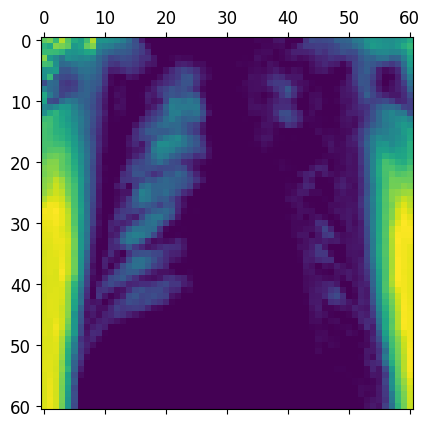

In [ ]:

grad_cam = GradCamEval()

decode_predictions = keras.applications.xception.decode_predictions

model = cnn_eval.get_model()

img_path = "chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
test_image = image.load_img(img_path, target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

img_array = preprocess_input(grad_cam.get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)

cnn_eval.get_training_set().class_indices

if preds[0][0] == 1:
  prediction = 'PNEUMONIA'
else:
  prediction = 'NORMAL'
print("Predicted:", prediction)

# Remove last layer's sigmoid
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = grad_cam.make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Displaying heatmap of convolutional layer of a single prediction
plt.matshow(heatmap)
plt.show()

### Apresentação dos Resultados do CNN + GradCam

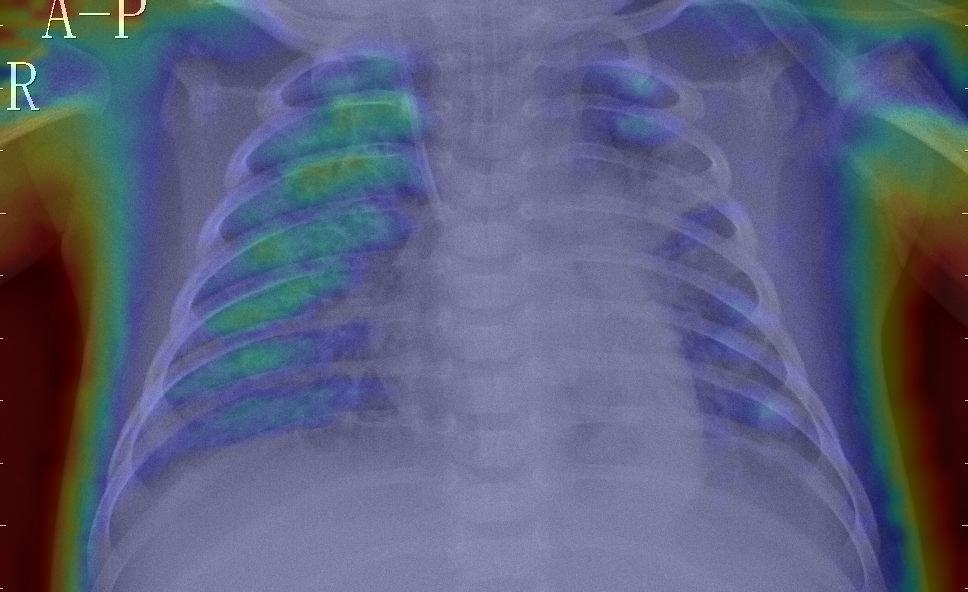

In [ ]:
# Joining heatmap of prediction with the real image to know which area to look 

grad_cam.save_and_display_gradcam(img_path, heatmap)

# Regressão Logística 

In [ ]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

datadir_train = 'chest_xray/train/'
datadir_test  = 'chest_xray/test/'

X, y = get_numpy(datadir_train)

X_test, y_test = get_numpy(datadir_test)

log_reg = LogisticRegression(max_iter=10000)

# Exploring the parameters of the regression, the cross validation has no major use besides this one
y_train_pred = cross_val_predict(log_reg, X, y, cv=3)

y_scores = cross_val_predict(log_reg, X, y, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y, y_scores)



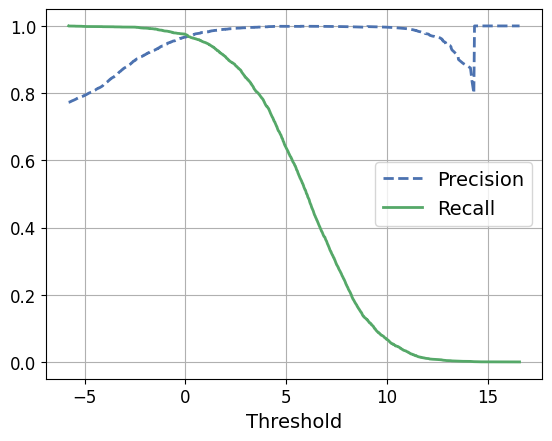

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

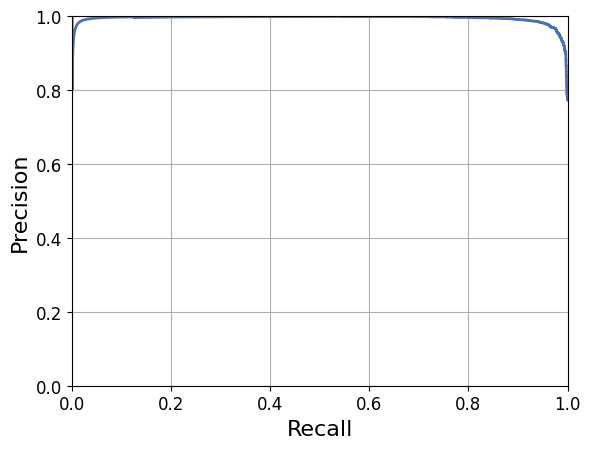

In [ ]:
plot_precision_vs_recall(precisions, recalls)

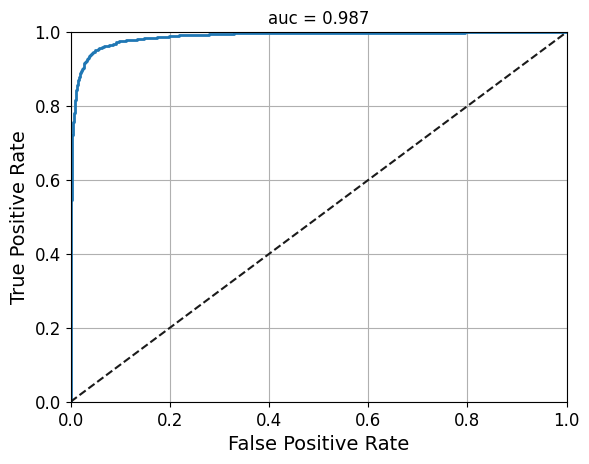

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_scores)
auc = roc_auc_score(y, y_scores)

plt.title('auc = {:.3f}'.format(auc))
plot_roc_curve(fpr, tpr)

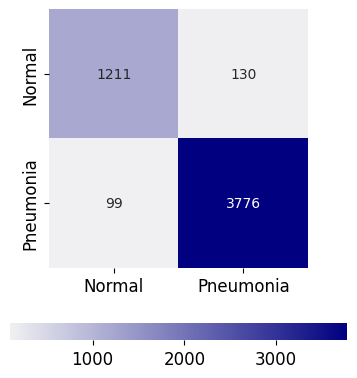

In [ ]:
matrix = confusion_matrix(y, y_train_pred)
plot_confusion_matrix(matrix)

## Apresentação dos Resultados da Regressão Logística


In [ ]:
# Final model
log_reg_final = LogisticRegression(max_iter=10000)
log_reg_final.fit(X, y)

LogisticRegression(max_iter=10000)

y_pred = log_reg_final.predict(X_test)

y_scores = log_reg_final.decision_function(X_test)

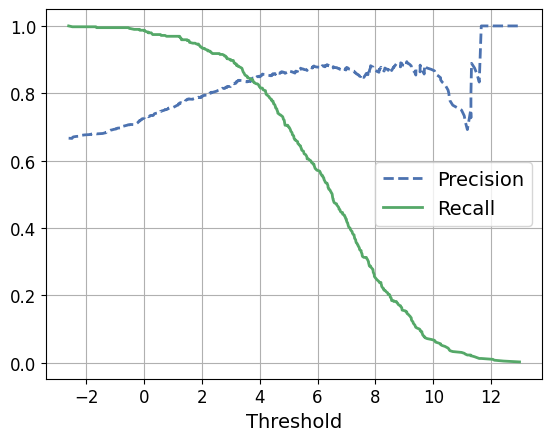

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.7277882797731569, 0.9871794871794872)

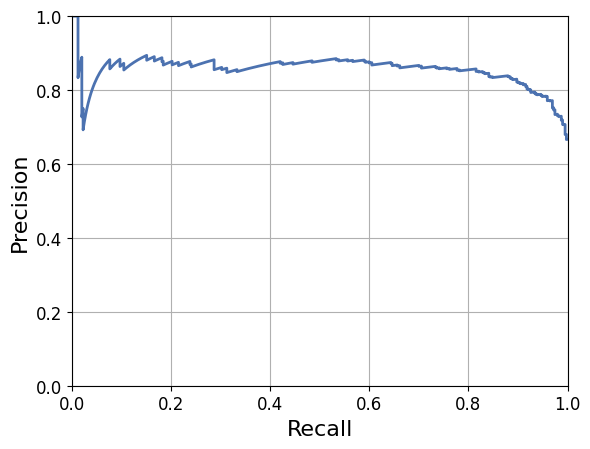

In [ ]:
plot_precision_vs_recall(precisions, recalls)

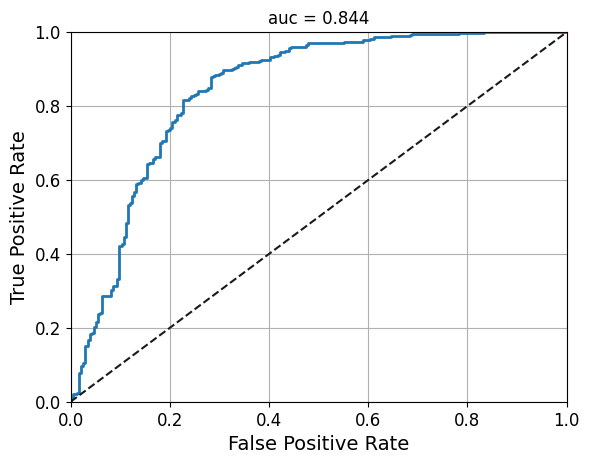

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

plt.title('auc = {:.3f}'.format(auc))
plot_roc_curve(fpr, tpr)

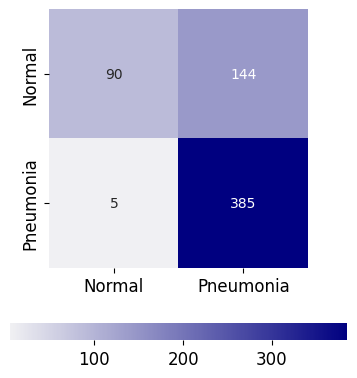

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix)